In [1]:
import numpy as np
import pandas as pd 
import xgboost as xgb
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix
from sklearn.model_selection import train_test_split,cross_val_score,KFold
pd.set_option('max_columns',30)


In [2]:
train=pd.read_csv('/Users/shashankjakka/Downloads/Dataset - Problem 2/train.csv',header=None)
test=pd.read_csv('/Users/shashankjakka/Downloads/Dataset - Problem 2/test.csv',header=None)
header=pd.read_csv('/Users/shashankjakka/Downloads/Dataset - Problem 2/header.csv')
sample=pd.read_csv('/Users/shashankjakka/Downloads/Dataset - Problem 2/sample_submission.csv')

In [ ]:
def impact_coding(data, feature, target='label'):
    '''
    In this implementation we get the values and the dictionary as two different steps.
    This is just because initially we were ignoring the dictionary as a result variable.
    
    In this implementation the KFolds use shuffling. If you want reproducibility the cv 
    could be moved to a parameter.
    '''
    n_folds = 3
    n_inner_folds = 3
    impact_coded = pd.Series()
    
    oof_default_mean = data[target].mean() # Gobal mean to use by default (you could further tune this)
    kf = KFold(n_splits=n_folds, shuffle=True)
    oof_mean_cv = pd.DataFrame()
    split = 0
    for infold, oof in kf.split(data[feature]):
            impact_coded_cv = pd.Series()
            kf_inner = KFold(n_splits=n_inner_folds, shuffle=True)
            inner_split = 0
            inner_oof_mean_cv = pd.DataFrame()
            oof_default_inner_mean = data.iloc[infold][target].mean()
            for infold_inner, oof_inner in kf_inner.split(data.iloc[infold]):
                # The mean to apply to the inner oof split (a 1/n_folds % based on the rest)
                oof_mean = data.iloc[infold_inner].groupby(by=feature)[target].mean()
                impact_coded_cv = impact_coded_cv.append(data.iloc[infold].apply(
                            lambda x: oof_mean[x[feature]]
                                      if x[feature] in oof_mean.index
                                      else oof_default_inner_mean
                            , axis=1))

                # Also populate mapping (this has all group -> mean for all inner CV folds)
                inner_oof_mean_cv = inner_oof_mean_cv.join(pd.DataFrame(oof_mean), rsuffix=inner_split, how='outer')
                inner_oof_mean_cv.fillna(value=oof_default_inner_mean, inplace=True)
                inner_split += 1

            # Also populate mapping
            oof_mean_cv = oof_mean_cv.join(pd.DataFrame(inner_oof_mean_cv), rsuffix=split, how='outer')
            oof_mean_cv.fillna(value=oof_default_mean, inplace=True)
            split += 1
            
            impact_coded = impact_coded.append(data.iloc[oof].apply(
                            lambda x: inner_oof_mean_cv.loc[x[feature]].mean()
                                      if x[feature] in inner_oof_mean_cv.index
                                      else oof_default_mean
                            , axis=1))

    return impact_coded, oof_mean_cv.mean(axis=1), oof_default_mean

In [3]:
print train.shape,test.shape

(406709, 56) (174303, 55)


In [4]:
train.columns=header.columns
test.columns=header.columns[:55]

In [5]:
train.head()

,key,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,...,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,label
0,447095,3452,111,22,433,214,3677,252,210,74,3316,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,113427,3093,95,9,124,7,4115,234,227,124,2930,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,66435,2551,61,17,90,5,726,231,202,98,751,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,8957,2944,135,3,430,13,1868,224,238,149,1199,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,434631,3030,327,34,277,101,1973,120,181,190,1693,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [6]:
train.iloc[:,11:-1].sum(axis=1).sum()/406709.0 ## two categorical variables one hotted into 44 categorical variables

2.0

In [7]:
## find the two categorical varibles
for i in range(11,56):
    print train.iloc[:,11:i].sum(axis=1).sum()/406709.0,i
    
## 11-14 one categorical variable, 16-55 another one

0.0 11
0.448726239153793 12
0.5001315436835674 13
0.9364484188940987 14
1.0 15
1.0052174896547654 16
1.0181800746971421 17
1.0264365922563798 18
1.0476778237019588 19
1.0504144240722482 20
1.0617935673909356 21
1.061973056903093 22
1.0622484380724302 23
1.0642695391545307 24
1.1204940141477076 25
1.1419786628768973 26
1.193563456918829 27
1.2235603342930694 28
1.2245659673132387 29
1.2245708848341197 30
1.2295105345591073 31
1.235411559616335 32
1.2387407212527877 33
1.2455711577565287 34
1.2614055749934228 35
1.2628267385280385 36
1.3203986142426156 37
1.4200841387822742 38
1.4566827879392883 39
1.457489261363776 40
1.4619027363544943 41
1.4637173015595917 42
1.465357294773413 43
1.6633932369335322 44
1.71529521107229 45
1.7596045329707481 46
1.8495558249264217 47
1.9275304947763634 48
1.930286765230177 49
1.9334905300841634 50
1.9337118185238094 51
1.9341912768097091 52
1.9611442087585964 53
1.9848564944468896 54
2.0 55


In [8]:
train.label.value_counts(normalize=True) ## equally balanced!

0    0.512288
1    0.487712
Name: label, dtype: float64

In [9]:
# train.isnull().sum() ## no nan's

In [10]:
# one hot to single column
train['cat_1']=train.iloc[:,11:15].values.argmax(axis=1)
test['cat_1']=test.iloc[:,11:15].values.argmax(axis=1)

train['cat_2']=train.iloc[:,15:-1].values.argmax(axis=1)
test['cat_2']=test.iloc[:,15:-1].values.argmax(axis=1)

In [70]:
target='label'
predictors=[x for x in train.columns if x not in [target,'var','impact_encoded_cat_2']+list(train.columns[11:55].values)]

In [12]:
# target='label'
# predictors=[x for x in train.columns if x not in ['key',target]]

In [13]:
train['sum']=train.loc[:,'V1':'V10'].sum(axis=1)
test['sum']=test.loc[:,'V1':'V10'].sum(axis=1)

In [14]:
# train['var']=train.loc[:,'V1':'V10'].std(axis=1)
# test['var']=test.loc[:,'V1':'V10'].std(axis=1)

In [15]:
# predictors.remove('cat_2')

In [86]:
X_train,X_test,y_train,y_test=train_test_split(train[predictors],train[target],test_size=0.3)

In [55]:
print X_train.shape,y_train.shape

(284696, 13) (284696,)


In [72]:
train[predictors].head()

,key,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,cat_1,cat_2,sum
0,447095,3452,111,22,433,214,3677,252,210,74,3316,2,38,11761
1,113427,3093,95,9,124,7,4115,234,227,124,2930,0,28,10958
2,66435,2551,61,17,90,5,726,231,202,98,751,0,22,4732
3,8957,2944,135,3,430,13,1868,224,238,149,1199,2,22,7203
4,434631,3030,327,34,277,101,1973,120,181,190,1693,2,32,7926


In [50]:
categorical_features=['cat_2']

In [51]:

# Apply the encoding to training and test data, and preserve the mapping# Apply 
impact_coding_map = {}
for f in categorical_features[:]:
    print("Impact coding for {}".format(f))
    train["impact_encoded_{}".format(f)], impact_coding_mapping, default_coding = impact_coding(train, f,'label')
    impact_coding_map[f] = (impact_coding_mapping, default_coding)
    mapping, default_mean = impact_coding_map[f]
    test["impact_encoded_{}".format(f)] = test.apply(lambda x: mapping[x[f]]
                                                                         if x[f] in mapping
                                                                         else default_mean
                                                               , axis=1)


Impact coding for cat_2


In [44]:
## All features have importances! 
for i in range(len(predictors)):
    bst,probs=run(X_train.loc[:,X_train.columns!=predictors[i]],y_train,X_test.loc[:,X_train.columns!=predictors[i]],params)
    print roc_auc_score(y_test,probs)

0.9233412503375773
0.9637042008659946
0.9626747098485731
0.9603980695445771
0.9621117965587815
0.9428611923641423
0.9643676237651209
0.9641220259861455
0.9631747862978866
0.9464211919853576
0.9596705063815393
0.9544401020724322


In [52]:
train.shape

(406709, 60)

In [76]:
# from xgboost.sklearn import XGBClassifier
# from sklearn.calibration import CalibratedClassifierCV
# xg=XGBClassifier(learning_rate=0.4,max_depth=20,n_estimators=700)

# cal=CalibratedClassifierCV(base_estimator=xg,cv=2)
# cal.fit(X_train,y_train)
# cpreds=cal.predict(X_test)
# print accuracy_score(y_test,cpreds)
# print confusion_matrix(y_test,cpreds)

In [75]:
# xg=XGBClassifier(learning_rate=0.4,max_depth=20,n_estimators=700)
# xg.fit(X_train,y_train)
# xpreds=xg.predict(X_test)
# print accuracy_score(y_test,xpreds)
# print confusion_matrix(y_test,xpreds)

In [83]:
bst,probs=run(X_train,y_train,X_test,params)
print roc_auc_score(y_test,probs)

0.9982231540842178


In [84]:
## gradient boosting
def run(train,lables,test,params):
    dtrain=xgb.DMatrix(train,label=lables)
    dtest=xgb.DMatrix(test)
    bst=xgb.train(dtrain=dtrain,params=params,num_boost_round=700)
    preds=bst.predict(dtest)
    return bst,preds

params={
    'objective':'binary:logistic',
    'max_depth':27,
    'eta':0.08,
    'subsample':0.9,
#     'eval_metric': 'auc'
}
    

In [ ]:
bst,probs=run(X_train,y_train,X_test,params)
print roc_auc_score(y_test,probs)

In [29]:
bst,probs=run(X_train,y_train,X_test,params)
print roc_auc_score(y_test,probs)

0.9980371880281691


In [20]:
preds=(probs>0.5).astype('int')
print accuracy_score(y_test,preds)
print confusion_matrix(y_test,preds)

0.9732405563341611
[[60832  1771]
 [ 1494 57916]]


In [78]:
bst,probs=run(train[predictors],train[target],test[predictors],params)

In [79]:
probs

array([9.9760097e-01, 9.9703950e-01, 8.1188893e-01, ..., 3.3300663e-03,
       9.9696046e-01, 9.0614434e-05], dtype=float32)

In [80]:
## put results 
result=pd.DataFrame()
result['key']=test.key
result['score']=probs

In [81]:
result.to_csv('/Users/shashankjakka/Downloads/Dataset - Problem 2/0.99824local14.08lr23d.csv',index=False)

# lgb500l0.01lr16d --> 0.96672

In [155]:
## Light gbm starts, fast but a bit less accuracy than xgb

In [18]:
import lightgbm as lgb
lgb_train = lgb.Dataset(train[predictors], train[target])
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [22]:
paramsl = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 500,
    'learning_rate': 0.01,
    'max_depth' : 16
}


In [23]:
gbm = lgb.train(paramsl,
                lgb_train,
                num_boost_round=8000)
                valid_sets=lgb_eval,
                feval=exp_met,
                early_stopping_rounds=100

In [24]:
lprobs=gbm.predict(test[predictors])

In [25]:
lprobs

array([9.98393670e-01, 9.90046993e-01, 8.80939867e-01, ...,
       9.68045661e-04, 9.99657191e-01, 3.80953725e-05])

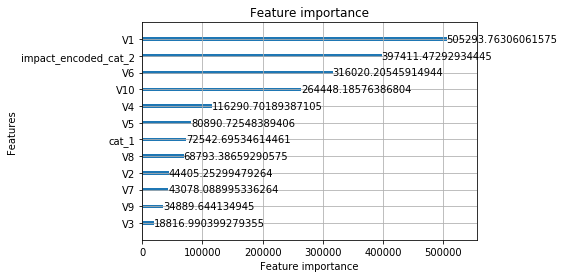

In [194]:
import matplotlib.pyplot as plt
%matplotlib inline
lgb.plot_importance(gbm,importance_type='gain')

In [204]:
lpreds=gbm.predict(test[predictors])

In [198]:
pd.Series(lpreds)

0         9.936960e-01
1         1.000000e+00
2         9.690191e-01
3         9.939958e-01
4         9.702435e-01
5         9.999625e-01
6         9.996421e-01
7         2.881391e-12
8         9.984350e-01
9         9.822939e-01
10        9.365729e-01
11        5.574606e-09
12        1.697048e-01
13        8.533031e-01
14        5.426467e-05
15        7.573846e-01
16        9.508662e-01
17        4.807048e-02
18        9.967710e-01
19        9.005926e-01
20        7.903912e-01
21        9.991511e-01
22        1.490232e-01
23        1.542870e-04
24        9.938509e-01
25        1.864600e-01
26        9.786288e-01
27        4.333691e-01
28        1.000000e+00
29        9.941212e-01
              ...     
174273    9.867369e-01
174274    1.835486e-09
174275    4.460764e-17
174276    9.999700e-01
174277    9.937459e-01
174278    3.229063e-04
174279    9.995765e-01
174280    2.560454e-02
174281    4.679931e-06
174282    2.745668e-03
174283    1.559425e-04
174284    1.175779e-09
174285    9

In [49]:
from scipy.stats import pearsonr

In [51]:
pearsonr(o.score,probs) ## both are not diverse enough for ensembling

(0.9940074605755469, 0.0)